# Dimensionality reduction and optimization

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display, HTML
from collections import defaultdict

np.set_printoptions(edgeitems=10, linewidth=500)

# Fix the dying kernel problem (only a problem in some installations - you can remove it, if it works without it)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Load data

In [2]:
seed = 6779
rng = np.random.RandomState(seed)

In [4]:
ml_ratings_df = pd.read_csv(os.path.join("data", "movielens_small", "ratings.csv")).rename(columns={'userId': 'user_id', 'movieId': 'item_id'})
ml_movies_df = pd.read_csv(os.path.join("data", "movielens_small", "movies.csv")).rename(columns={'movieId': 'item_id'})
ml_df = pd.merge(ml_ratings_df, ml_movies_df, on='item_id')

# Filter the data to reduce the number of movies
left_ids = [1, 318, 1193, 1208, 1214, 1721, 2959, 3578, 4306, 109487]

ml_ratings_df = ml_ratings_df.loc[ml_ratings_df['item_id'].isin(left_ids)]
ml_movies_df = ml_movies_df.loc[ml_movies_df['item_id'].isin(left_ids)]
ml_df = ml_df.loc[ml_df['item_id'].isin(left_ids)]

display(ml_movies_df)

print("Number of interactions left: {}".format(len(ml_ratings_df)))

,item_id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
896,1193,One Flew Over the Cuckoo's Nest (1975),Drama
909,1208,Apocalypse Now (1979),Action|Drama|War
915,1214,Alien (1979),Horror|Sci-Fi
1291,1721,Titanic (1997),Drama|Romance
2226,2959,Fight Club (1999),Action|Crime|Drama|Thriller
2674,3578,Gladiator (2000),Action|Adventure|Drama
3194,4306,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...
8376,109487,Interstellar (2014),Sci-Fi|IMAX


Number of interactions left: 1689


## Shift item ids and user ids so that they are consecutive

In [5]:
interactions_df = ml_ratings_df.copy()

unique_item_ids = interactions_df['item_id'].unique()
item_id_mapping = dict(zip(unique_item_ids, list(range(len(unique_item_ids)))))
item_id_reverse_mapping = dict(zip(list(range(len(unique_item_ids))), unique_item_ids))
unique_user_ids = interactions_df['user_id'].unique()
user_id_mapping = dict(zip(unique_user_ids, list(range(len(unique_user_ids)))))
user_id_reverse_mapping = dict(zip(list(range(len(unique_user_ids))), unique_user_ids))

interactions_df.replace({'item_id': item_id_mapping, 'user_id': user_id_mapping}, inplace=True)

display(interactions_df.head(10))

,user_id,item_id,rating,timestamp
0,0,0,4.0,964982703
72,0,1,4.0,964983250
75,0,2,4.0,964981855
192,0,3,5.0,964983282
219,0,4,5.0,964980668
232,1,5,3.0,1445714835
235,1,4,4.0,1445714885
255,1,6,3.0,1445715145
458,2,3,2.0,945078528
516,3,0,4.0,847434962


## Get the number of items and users

In [6]:
n_items = np.max(interactions_df['item_id']) + 1
n_users = np.max(interactions_df['user_id']) + 1

print("n_items={}\nn_users={}".format(n_items, n_users))

n_items=10
n_users=521


## Get the user-item interaction matrix

In [7]:
# mapping to int is necessary because of how iterrows works
r = np.zeros(shape=(n_users, n_items))
for idx, interaction in interactions_df.iterrows():
    r[int(interaction['user_id'])][int(interaction['item_id'])] = 1
    
print(r)

[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 ...
 [1. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]]


# Dimensionality reduction

## PCA (Principal Component Analysis)

**Task 1.** Apply PCA (Principal Component Analysis) to the rows (user representations) of the interaction matrix into two dimensions. Use sklearn.decomposition.PCA. Set the transformed rows to the pca_reduced_r variable.

In [12]:
# Write your code here
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

pca_reduced_r = pca.fit_transform(r)

pca_reduced_r

array([[ 0.71220087,  0.59638113],
       [-0.2960829 , -0.46776347],
       [-0.53937767, -0.09093342],
       [-0.5448051 ,  0.00473207],
       [-0.81971772, -0.44796768],
       [ 0.35131256,  0.96850927],
       [-0.81971772, -0.44796768],
       [ 0.38822784,  0.05813759],
       [-0.49491171, -0.26936765],
       [-0.65898702,  0.4652029 ],
       ...,
       [ 1.44723913, -0.1585195 ],
       [-0.81971772, -0.44796768],
       [ 1.33222423,  0.66159484],
       [-0.70888041,  0.73930263],
       [-0.30490972,  0.90816943],
       [ 1.90027024,  0.09589109],
       [-0.22436146,  0.17900703],
       [ 1.90027024,  0.09589109],
       [-0.5448051 ,  0.00473207],
       [ 1.72047472,  0.13196553]])

### Plot the reduced data

In [13]:
def plot_unique_datapoints_2d(data, tolerance=0.000001):
    
    max_value = np.max(np.abs(data))
    
    # Round the data so that points closer than tolerance are mapped into the same coordinates
    
    rounded_data = np.round(data, int(np.log10(1 / tolerance)))
    
    # Choose the first representative from each group mapped into the same coordinates
    
    unique_representations, indices = np.unique(rounded_data, return_index=True, axis=0)
    
    # Plot

    fig = plt.figure(tight_layout=True)
    fig.set_size_inches(16, 9)
    ax1 = fig.add_subplot(1, 1, 1)

    sns.scatterplot(x=data[indices, 0], y=data[indices, 1], ax=ax1)

    for i in indices:
        plt.text(x=data[i, 0] + max_value / 150, y=data[i, 1] + max_value / 150, s=i, 
                 fontdict=dict(color='red', size=8))

    plt.show()

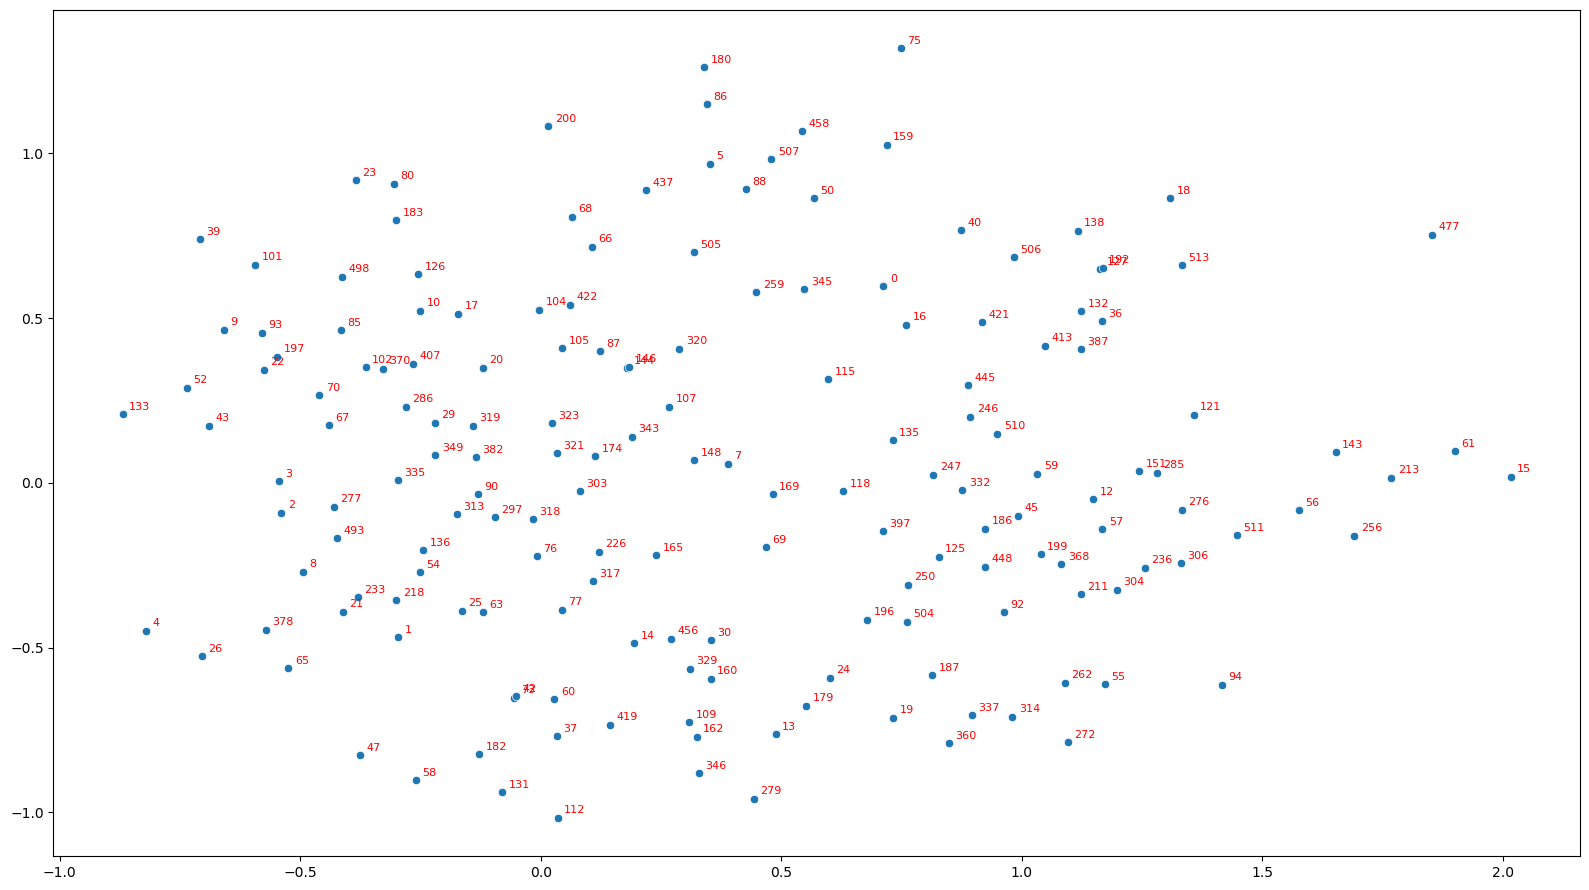

In [14]:
plot_unique_datapoints_2d(pca_reduced_r, tolerance=0.1)

### Print representations for chosen pairs of users close on the graph

Notice that their initial represenation in the interaction matrix was also similar.

In [15]:
def print_representations(chosen_user_id_groups, representations, reduced_representations):
    for user_id_group in chosen_user_id_groups:
        for user_id in user_id_group:
            print("User {} full representation and reduced representation".format(user_id))
            print(representations[user_id])
            print(reduced_representations[user_id])
            print()
        print("==============================")

In [16]:
chosen_user_ids = [(0, 16), (133, 52), (75, 159), (279, 346), (15, 61)]
print_representations(chosen_user_ids, r, pca_reduced_r)

User 0 full representation and reduced representation
[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
[0.71220087 0.59638113]

User 16 full representation and reduced representation
[1. 0. 1. 1. 1. 0. 0. 0. 0. 1.]
[0.75940893 0.48017106]

User 133 full representation and reduced representation
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[-0.86837121  0.209291  ]

User 52 full representation and reduced representation
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[-0.73578375  0.28942663]

User 75 full representation and reduced representation
[1. 0. 1. 0. 1. 0. 0. 1. 1. 0.]
[0.74855292 1.3185605 ]

User 159 full representation and reduced representation
[1. 0. 1. 0. 1. 0. 0. 1. 0. 1.]
[0.71896426 1.02657416]

User 279 full representation and reduced representation
[0. 0. 0. 1. 1. 1. 1. 0. 0. 1.]
[ 0.44354981 -0.95868608]

User 346 full representation and reduced representation
[0. 0. 0. 1. 1. 1. 0. 0. 0. 1.]
[ 0.32812798 -0.8813742 ]

User 15 full representation and reduced representation
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[2.015

### Topology of distant datapoints

**Task 2.** Write a method which returns a pair of indices of datapoints with the highest discrepancy between the distance in the reduced space and the original distance measured as:

<center>
$$
    \frac{d(x_{reduced}, y_{reduced})}{\text{max}(d(x, y), 0.001)}
$$
</center>

where $d$ is the Euclidean distance. The interface for the method:

    find_poorest_reduction(orig_data, reduced_data)

Find the pair of user ids with the highest discrepancy for the PCA reduction and set those ids to pca_user_id_1 and pca_user_id_2.

You can a loop over all pairs.

In [58]:
# Write your code here
def find_poorest_reduction(orig_data, reduced_data):
    pca_user_id_1, pca_user_id_2 = -1, -1
    
    highest = -1e100
    
    for idx1, user1 in enumerate(orig_data):
        for idx2, user2 in enumerate(orig_data):
            dist_orig_data = np.linalg.norm(user2 - user1)
            dist_reduced_data = np.linalg.norm(reduced_data[idx2] - reduced_data[idx1])
                        
            distance = dist_orig_data / (dist_reduced_data+1)
            
            if distance > highest:
                highest = distance
                pca_user_id_1 = idx1
                pca_user_id_2 = idx2
                
    return pca_user_id_1, pca_user_id_2

In [59]:
pca_user_id_1, pca_user_id_2 = find_poorest_reduction(r, pca_reduced_r)

In [60]:
chosen_user_ids = [(pca_user_id_1, pca_user_id_2)]
print_representations(chosen_user_ids, r, pca_reduced_r)

User 7 full representation and reduced representation
[0. 0. 0. 1. 1. 0. 1. 1. 0. 0.]
[0.38822784 0.05813759]

User 148 full representation and reduced representation
[1. 1. 1. 0. 0. 1. 0. 0. 0. 1.]
[0.31886517 0.06844447]



Interpretation: if the original vectors for the chosen pair are far away from each other, then this means that the reduction properly kept distances between points which were far away in the original space. Otherwise, it means that the reduction lost an important piece of topological information from the original space.

## tSNE

**Task 3.** Apply tSNE to the rows (user representations) of the interaction matrix into two dimensions. Use sklearn.manifold.TSNE (with init='pca'). Set the transformed rows to the tsne_reduced_r variable.

In [61]:
# Write your code here

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca')

tsne_reduced_r = tsne.fit_transform(r)

In [62]:
tsne_reduced_r

array([[ 22.20976   ,   2.5332382 ],
       [ -2.3751857 , -17.5186    ],
       [ -3.1992986 ,  -1.3814034 ],
       [ 10.065162  ,  16.747154  ],
       [-11.203331  , -16.236387  ],
       [ -2.6274092 ,  14.360981  ],
       [ -9.501559  , -16.468115  ],
       [  1.2531571 ,   0.7224442 ],
       [-11.247996  , -10.782165  ],
       [-10.968004  ,   7.1120706 ],
       ...,
       [ 14.664606  ,  -5.752175  ],
       [-11.675282  , -17.901821  ],
       [ 20.931423  ,   1.2245288 ],
       [ -6.975701  ,  17.402979  ],
       [ -3.7275445 ,  12.953897  ],
       [ 19.58679   ,  -0.14010647],
       [  8.87037   ,  13.922546  ],
       [ 19.58679   ,  -0.14010647],
       [  9.106656  ,  17.976877  ],
       [ 18.284794  ,  -3.68718   ]], dtype=float32)

### Plot the reduced data

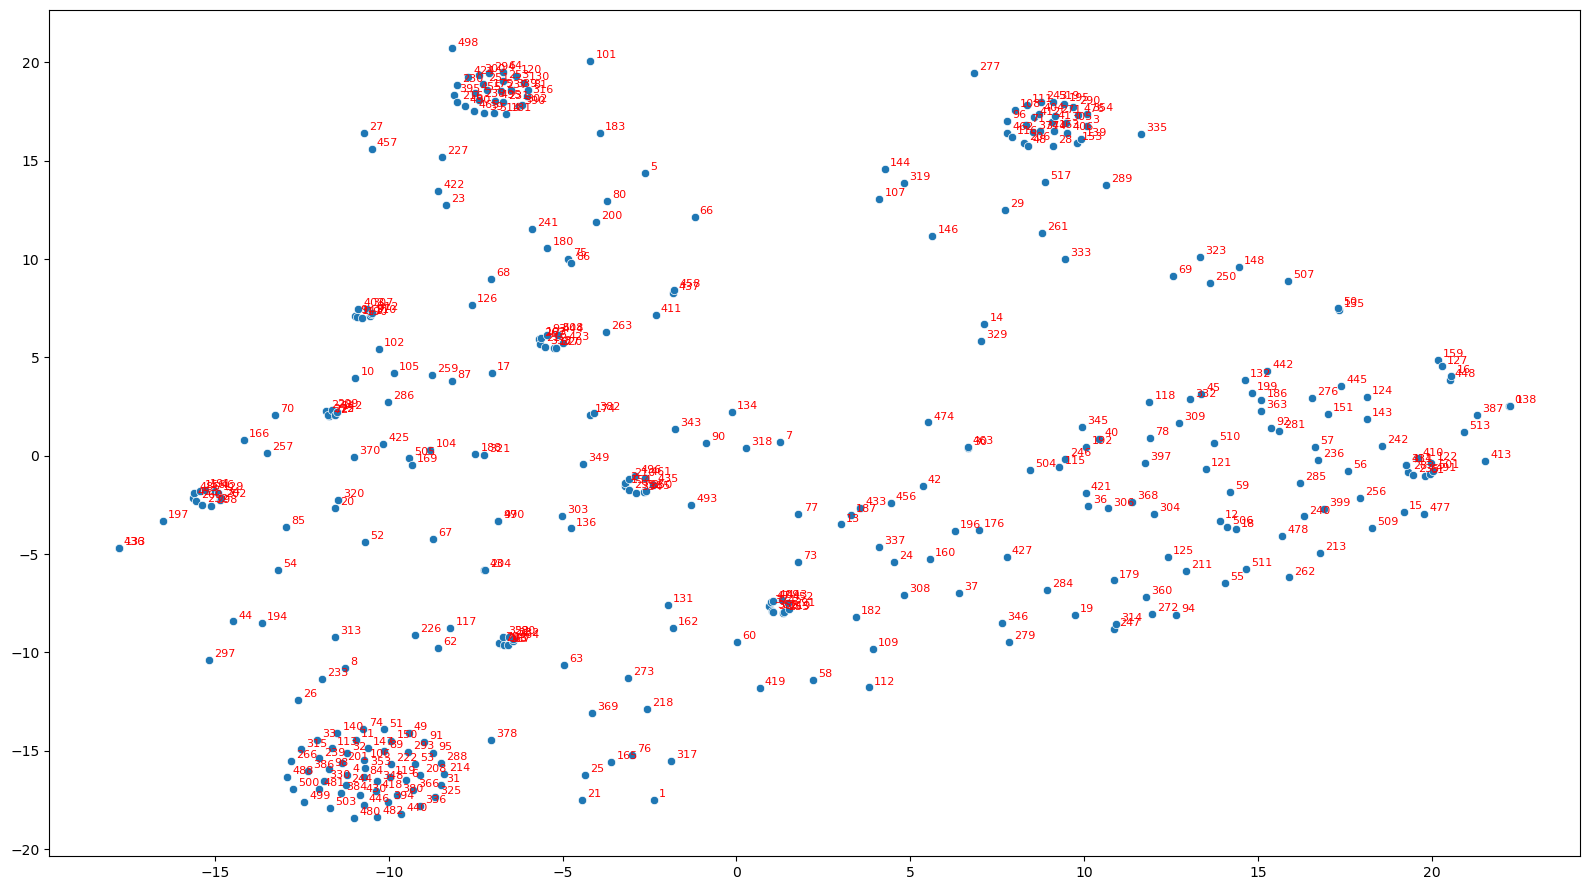

In [63]:
plot_unique_datapoints_2d(tsne_reduced_r, tolerance=0.1)

### Print tSNE representations for chosen pairs of users close on the PCA graph

In [64]:
chosen_user_ids = [(0, 16), (133, 52), (75, 159), (279, 346), (15, 61)]
print_representations(chosen_user_ids, r, tsne_reduced_r)

User 0 full representation and reduced representation
[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
[22.20976    2.5332382]

User 16 full representation and reduced representation
[1. 0. 1. 1. 1. 0. 0. 0. 0. 1.]
[20.557657  4.047047]

User 133 full representation and reduced representation
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[-17.74675   -4.673507]

User 52 full representation and reduced representation
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[-10.671664   -4.3634386]

User 75 full representation and reduced representation
[1. 0. 1. 0. 1. 0. 0. 1. 1. 0.]
[-4.8488007 10.009855 ]

User 159 full representation and reduced representation
[1. 0. 1. 0. 1. 0. 0. 1. 0. 1.]
[20.168468  4.866119]

User 279 full representation and reduced representation
[0. 0. 0. 1. 1. 1. 1. 0. 0. 1.]
[ 7.8269954 -9.451126 ]

User 346 full representation and reduced representation
[0. 0. 0. 1. 1. 1. 0. 0. 0. 1.]
[ 7.6334906 -8.517334 ]

User 15 full representation and reduced representation
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[19.187164  -2.8

### Print tSNE representations for chosen pairs of users close on the tSNE graph

Notice that those clusters of points represent points with exactly the same interaction vector. In PCA they were mapped into the same point, but tSNE separates all points.

In [65]:
chosen_user_ids = [(81, 39, 120, 101), (11, 49, 288, 378), (14, 329), (150, 127, 148)]
print_representations(chosen_user_ids, r, tsne_reduced_r)

User 81 full representation and reduced representation
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-5.989178 18.570587]

User 39 full representation and reduced representation
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-7.2665825 17.441805 ]

User 120 full representation and reduced representation
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-6.337624 19.290466]

User 101 full representation and reduced representation
[1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[-4.2055416 20.076258 ]

User 11 full representation and reduced representation
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[-10.93875  -14.445493]

User 49 full representation and reduced representation
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[ -9.424267 -14.100508]

User 288 full representation and reduced representation
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[ -8.502534 -15.607634]

User 378 full representation and reduced representation
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
[ -7.0471835 -14.440351 ]

User 14 full representation and reduced representation
[1. 0. 0. 1. 0. 1. 0. 0. 0. 1.]
[7.128472  6.72

### Topology of distant datapoints

**Task 4.** Find the pair of user ids with the highest discrepancy for the tSNE reduction and set those ids to tsne_user_id_1 and tsne_user_id_2.

In [69]:
# Write your code here

def find_poorest_reduction(orig_data, reduced_data):
    tsne_user_id_1, tsne_user_id_2 = -1, -1
    
    highest = -1e100
    
    for idx1, user1 in enumerate(orig_data):
        for idx2, user2 in enumerate(orig_data):
            dist_orig_data = np.linalg.norm(user2 - user1)
            dist_reduced_data = np.linalg.norm(reduced_data[idx2] - reduced_data[idx1])
                        
            distance = dist_orig_data / (dist_reduced_data+1)
            
            if distance > highest:
                highest = distance
                tsne_user_id_1 = idx1
                tsne_user_id_2 = idx2
                
    return tsne_user_id_1, tsne_user_id_2

In [70]:
tsne_user_id_1, tsne_user_id_2 = find_poorest_reduction(r, tsne_reduced_r)

In [71]:
chosen_user_ids = [(tsne_user_id_1, tsne_user_id_2)]
print_representations(chosen_user_ids, r, tsne_reduced_r)

User 66 full representation and reduced representation
[1. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
[-1.2073096 12.129584 ]

User 88 full representation and reduced representation
[1. 0. 1. 0. 0. 0. 1. 1. 0. 1.]
[-1.1614355 12.124485 ]



# Matrix factorization

## SVD (Singular Value Decomposition)

**Task 5.** Implement a method for performing SVD for an arbitrary matrix and returning the two submatrices corresponding to the $k$ biggest eigenvalues - the matrix consisting of the $k$ first columns of $P$ multiplied by the matrix consisting of the first $k$ rows and columns of $\Sigma$ (that's the first matrix in decomposition), the matrix consisting of the first $k$ columns of $Q$ (compare the lecture). For $k$ equal to None return the full decomposition. Return a tuple with both resulting matrices. 

Use numpy.linalg.svd to perform SVD. Note that this method does not return a diagonal matrix as the second matrix, but only a vector of singular values. To perform the matrix multiplication as suggested in the lecture you have to transform it into a diagonal matrix (for instance with np.diag). Note also that the $Q$ matrix returned by this method is already transposed (you have to revert the transposition). To make the calculations easier you can use this method with full_matrices=False. It will cut the matrices to the sizes $m \text{x} k$, $k \text{x} k$, $k \text{x} n$, where $m$ is the number of rows in the original matrix, $k$ is the number of non-zero eigenvalues, $n$ is the number of columns in the original matrix.

The interface of the method should have the following form:

    perform_svd(r, k=None)

To test the method decompose the matrix defined in the cell below for the following values of $k$: None, 6, 5, 4, 3, 2, 1, and then reconstruct the original matrix by multiplying the matrices from the decomposition. For every $k$ calculate and print the element-wise difference between the original matrix and the matrix retrieved from the decomposition and calculate and print the Euclidean distance between the matrices (take the the square of every element in the difference matrix, sum them up and take the square root - that's the same formula as for RMSE). You can also print the decomposition for every $k$ to see how it looks like.

Compare the decomposition given in the lecture with the one given by your method for $k = 2$ and compare the reconstructed matrices distance to the original. Which decomposition is better (i.e. gives a closer approximation)?

In [74]:
r_aggarwal = [
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 1, 1],
    [-1, -1, -1, 1, 1, 1],
    [-1, -1, 1, 1, 1, 1],
    [-1, -1, -1, 1, 1, 1],
]

from numpy.linalg import svd

# Write your code here

# u, s, vh = P, E, Q
def perform_svd(r, k=None):
    u, s, vh = svd(r, full_matrices=False)
    vh = vh.T
    
    if k is not None:
        u = u[:, :k]
        s = s[:k]
        vh = vh[:, :k]
    
    return np.matmul(u, np.diag(s)), vh

In [77]:
# Test the method
# Write your code here

test_k = [None, 6, 5, 4, 3, 2, 1]

for k in test_k:
    p, q = perform_svd(r_aggarwal, k)
    r_retrieved = np.matmul(p, q.T)
    diff = r_aggarwal - r_retrieved

    print("Dimension")
    print(k)
    print()
    print("User representations")
    print(p)
    print()
    print("Item representations")
    print(q.T)
    print()
    print("Matrix recreated from the decomposition")
    print(r_retrieved)
    print()
    print("Difference between original and decomposed")
    print(diff)
    print()
    print("RMSE")
    print(np.sqrt(np.sum(np.power(diff, 2))))
    print("==============================")

Dimension
None

User representations
[[-1.52944296e+00 -8.12663674e-01  1.95447931e-02 -3.11222111e-16 -2.46294110e-32 -4.98328243e-50]
 [-1.52944296e+00 -8.12663674e-01  1.95447931e-02  3.09293014e-17  1.83837790e-32 -6.00355091e-49]
 [-1.52944296e+00 -8.12663674e-01  1.95447931e-02  2.60722048e-16 -3.26764275e-32 -6.75761775e-51]
 [-7.42924033e-01 -2.28152330e+00  4.92661472e-01  9.78538084e-18  1.94610297e-32  3.28472767e-49]
 [ 2.31596188e+00 -6.56195950e-01  4.53571886e-01 -4.89269042e-18 -9.73051486e-33 -1.64236383e-49]
 [ 1.48999326e+00 -1.60022004e+00 -1.10418110e+00  1.04957678e-31 -3.79582926e-48 -6.12368782e-65]
 [ 2.31596188e+00 -6.56195950e-01  4.53571886e-01 -4.89269042e-18 -9.73051486e-33 -1.64236383e-49]]

Item representations
[[-5.58229324e-01 -5.58229324e-01 -4.12984307e-01  2.62172974e-01  2.62172974e-01  2.62172974e-01]
 [-1.70325815e-01 -1.70325815e-01 -4.72012043e-01 -4.89619874e-01 -4.89619874e-01 -4.89619874e-01]
 [ 3.99210644e-01  3.99210644e-01 -7.78876494e-01

## Application of the SVD decomposition to obtain 2D representation of users for the movielens dataset subset

In [78]:
svd_reduced_r, _ = perform_svd(r, k=2)

### Plot the reduced data

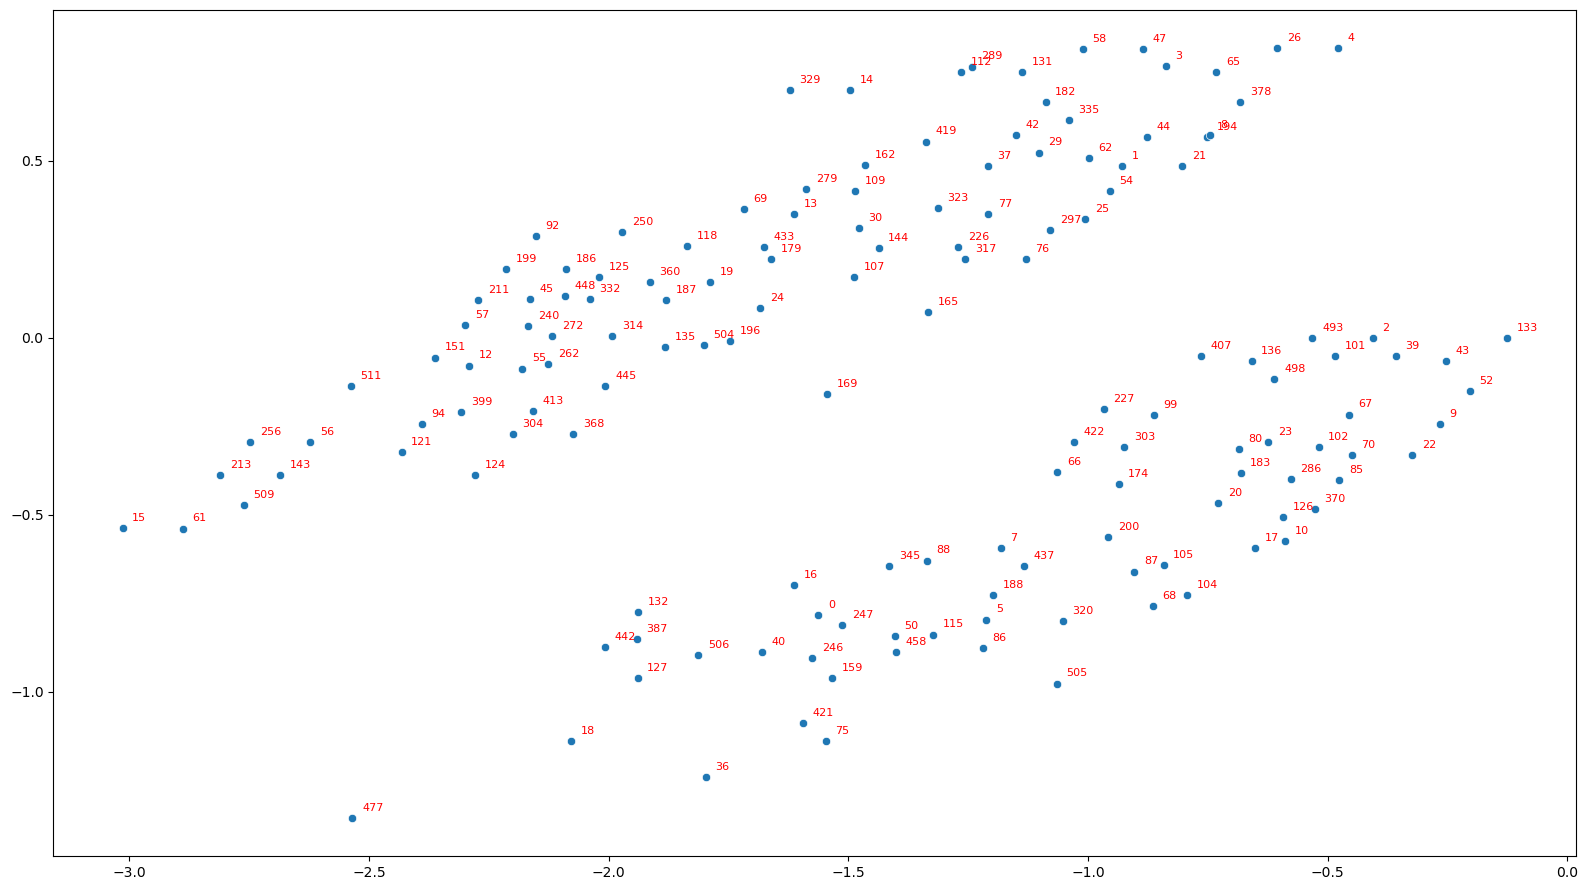

In [79]:
plot_unique_datapoints_2d(svd_reduced_r, tolerance=0.1)

### Print representations for chosen pairs of users close on the graph

In [80]:
chosen_user_ids = [(15, 61, 213), (65, 26, 4), (413, 304), (86, 320, 505), (43, 52, 133)]
print_representations(chosen_user_ids, r, svd_reduced_r)

User 15 full representation and reduced representation
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-3.01364393 -0.53889763]

User 61 full representation and reduced representation
[1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
[-2.88782982 -0.53898616]

User 213 full representation and reduced representation
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[-2.81043269 -0.38781381]

User 65 full representation and reduced representation
[0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
[-0.73220749  0.75196244]

User 26 full representation and reduced representation
[0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
[-0.60506937  0.8179285 ]

User 4 full representation and reduced representation
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[-0.47925526  0.81783996]

User 413 full representation and reduced representation
[1. 1. 1. 0. 0. 1. 0. 1. 1. 1.]
[-2.15856462 -0.20648465]

User 304 full representation and reduced representation
[0. 0. 1. 1. 1. 1. 1. 1. 1. 0.]
[-2.1996283 -0.2715007]

User 86 full representation and reduced representation
[1. 0. 1. 0. 1. 0. 0. 0. 1. 0.]
[

### Topology of distant datapoints

In [81]:
svd_user_id_1, svd_user_id_2 = find_poorest_reduction(r, svd_reduced_r)

In [82]:
chosen_user_ids = [(svd_user_id_1, svd_user_id_2)]
print_representations(chosen_user_ids, r, svd_reduced_r)

User 272 full representation and reduced representation
[0. 1. 0. 1. 1. 1. 1. 1. 0. 1.]
[-2.11765122  0.00570611]

User 510 full representation and reduced representation
[1. 0. 1. 1. 0. 1. 0. 1. 1. 0.]
[-2.10817282  0.01002791]



# Optimization

**Task 6.** Write a method perform_sgd for performing n_steps of stochastic gradient descent (SGD) for a given alpha for a linear fit to a 2D dataset. The method should return a tuple of fitted theta_0 and theta_1. Write all the updating formulas yourself.

The interface of the method should be as follows:
    
    perform_sgd(data, theta_0_init, theta_1_init, n_steps, alpha)
    
Test several initial pairs of theta_0 and theta_1, and several values of n_steps and alpha. Does the method always converge to the same solution?

You can also compare your solution to the optimal one found by sklearn.linear_model.LinearRegression.
    
Plot the data (as scatterplot) and the fit (as lineplot) on a single seaborn chart.

In [145]:
data = np.array([
    [0.2, 0.52],
    [0.5, 1.36],
    [0.9, 1.00],
    [1.3, 1.69],
    [1.5, 2.58],
    [2.8, 2.34]
])

# Write your code here

def perform_sgd(data, theta_0_init, theta_1_init, n_steps, alpha):
    theta_0 = theta_0_init
    theta_1 = theta_1_init
    m = len(data)

    for i in range(n_steps):
        j = np.random.randint(m)
        y = data[j, 1]
        x = data[j, 0]

        # Calculate the gradient for the selected data point
        grad_theta_0 = -2 * (y - (theta_1 * x + theta_0))
        grad_theta_1 = -2 * x * (y - (theta_1 * x + theta_0))

        # Update the parameters
        theta_0 = theta_0 - (alpha * grad_theta_0)
        theta_1 = theta_1 - (alpha * grad_theta_1)

    return (theta_0, theta_1)

In [169]:
theta_0, theta_1 = perform_sgd(data, theta_0_init=0, theta_1_init=0, n_steps=10, alpha=0.1)
assert np.abs(theta_0 - 0.6639166956551464) < 0.1
assert np.abs(theta_1 - 0.7428743752061177) < 0.1